In [1]:
import pandas as pd
import numpy as np
import gc
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler as SS
from sklearn.preprocessing import MinMaxScaler


from myutils import reduce_mem_usage

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

categorical = []

In [2]:
def loadfeather(trpath, tepath, reader=pd.read_feather):
    train = reader(trpath)
    test = reader(tepath)
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    df = pd.concat([train, test])
    del train, test; gc.collect()
    print(df.nunique())
    return df

def plothist(df):
    sidesplit = 3
    versplit = len(df.columns)//sidesplit + 1
    width = 4*sidesplit
    height = 3*versplit
    plt.figure(figsize=(width, height))
    for i, col in enumerate(df.columns):
        plt.subplot(versplit, sidesplit, i+1)
        plt.hist(df.iloc[:, i], label=col) 
        plt.legend()
    plt.show()

def plotcorr(df):
    colsize = len(df.columns)
    width = 6 + np.uint(colsize*0.2)
    height = 4 + np.uint(colsize*0.2)
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.set(style='white')
    f, ax = plt.subplots(figsize=(width, height))
    cmap = sns.diverging_palette(30, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
def concat2master(df, dfmaster):
    print(df.shape)
    #print(df.isnull().sum())
    df = reduce_mem_usage(df)
    #print(df.columns)
    #print(df.dtypes)
    for col in df.columns:
        dfmaster[col] = df[col]
    del df; gc.collect()
    print(dfmaster.shape)
    print(dfmaster.memory_usage().sum() / 1024**2, ' MB')
    return dfmaster

def scale_standard(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        #print(col)
        if (str(df[col].dtype)[:5] == 'float') and (not col in ignorecol):
            temp = SS().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

def scale_minmax(df, ignorecol=[]):
    cols = deepcopy(df.columns)
    for col in cols:
        if (str(df[col].dtype)[:3] == 'int') or (str(df[col].dtype)[:4] == 'uint'):
            print(col)
            temp = MinMaxScaler().fit_transform(df[col].values.ravel().reshape(-1, 1))
            df[col] = temp.flatten()
    return df

In [3]:
dfmaster = pd.DataFrame()

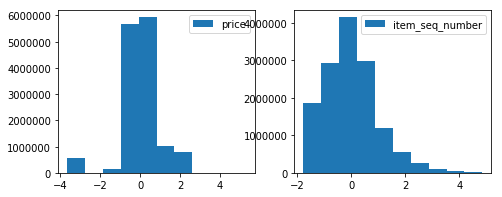

(14129821, 2)
Memory usage of dataframe is 107.80 MB
Memory usage after optimization is: 107.80 MB
Decreased by 0.0%
(14129821, 9)
242.55452919006348  MB


7

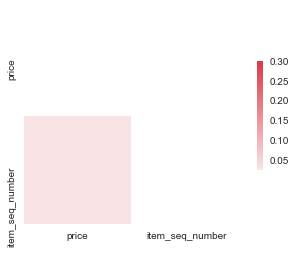

In [7]:
# Raw Numeric Features
nume_dtypes = {'price': 'float32', 'item_seq_number': 'float32'}
df = pd.read_csv('../input/train_active.csv', usecols=['price', 'item_seq_number'], dtype=nume_dtypes)

df['price'] = np.log(df['price']+0.001)
df['price'].fillna(df['price'].mean(), inplace=True)
df['item_seq_number'] = np.log1p(df['item_seq_number'])
df['item_seq_number'].fillna(df['item_seq_number'].mean(), inplace=True)

df = scale_standard(df)
plothist(df)
plotcorr(df)

dfmaster = concat2master(df, dfmaster)
del df; gc.collect()

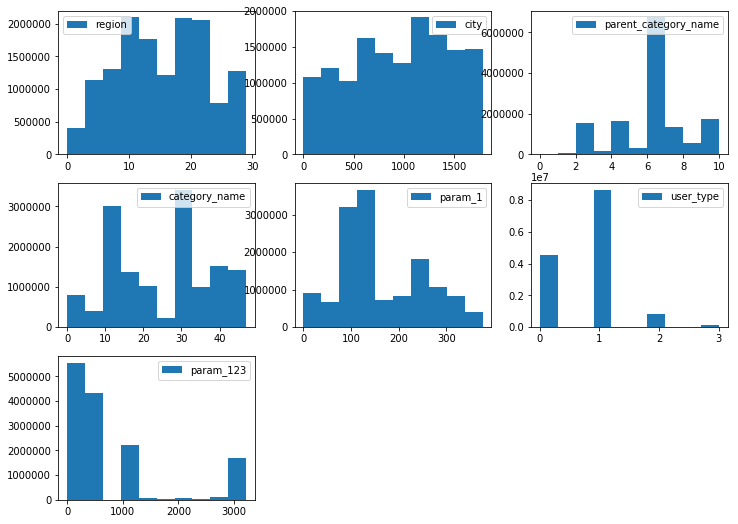

(14129821, 7)
Memory usage of dataframe is 134.75 MB
Memory usage after optimization is: 134.75 MB
Decreased by 0.0%
(14129821, 7)
134.75255012512207  MB


In [6]:
# Categorical Features
df = pd.read_feather('../features/train_active/categorical_features_train_active.feather')
df.drop(['user_id', 'param_2', 'param_3', 'weekofday'], axis=1, inplace=True)
plothist(df)
dfmaster = concat2master(df, dfmaster)
categorical += df.columns.tolist()

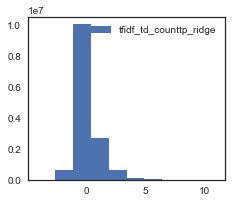

(14129821, 1)
Memory usage of dataframe is 107.80 MB
Memory usage after optimization is: 53.90 MB
Decreased by 50.0%
(14129821, 10)
296.4555187225342  MB


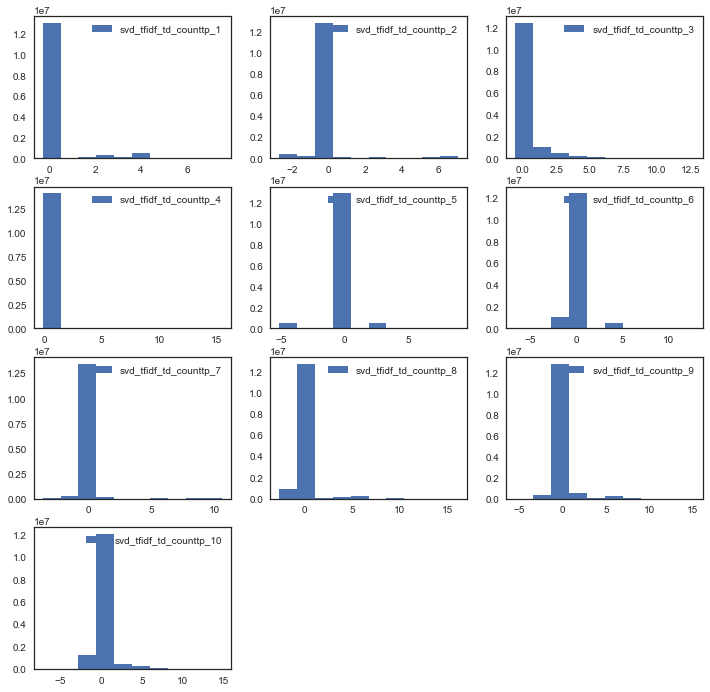

(14129821, 10)
Memory usage of dataframe is 1078.02 MB
Memory usage after optimization is: 539.01 MB
Decreased by 50.0%
(14129821, 20)
835.4654140472412  MB


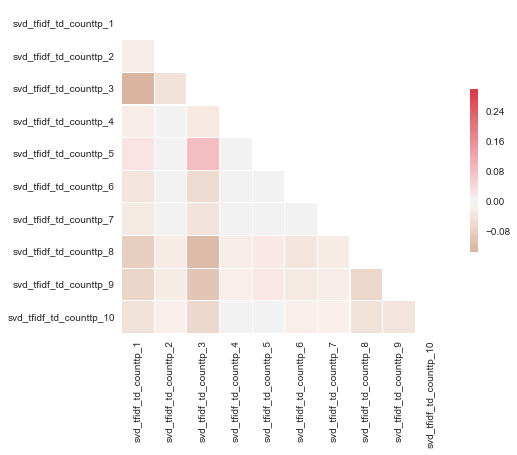

In [8]:
# TFIDF Features
df = pd.read_feather('../features/train_active/tfidf_td_counttp_ridge_train_active.feather')
df = scale_standard(df)
plothist(df)
dfmaster = concat2master(df, dfmaster)

df = pd.read_feather('../features/train_active/tfidf_td_counttp_tsvd_train.feather')
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

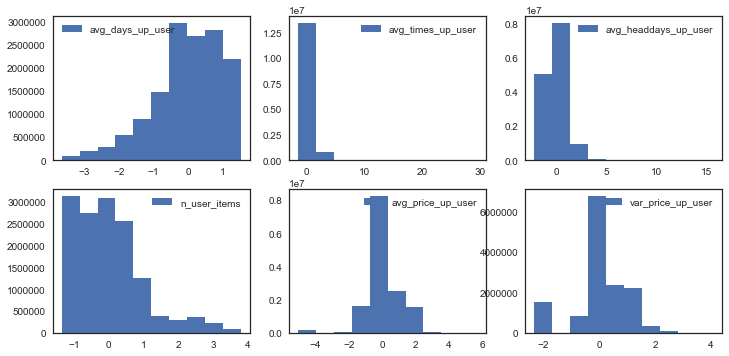

(14129821, 6)
Memory usage of dataframe is 323.41 MB
Memory usage after optimization is: 323.41 MB
Decreased by 0.0%
(14129821, 26)
1158.8713512420654  MB


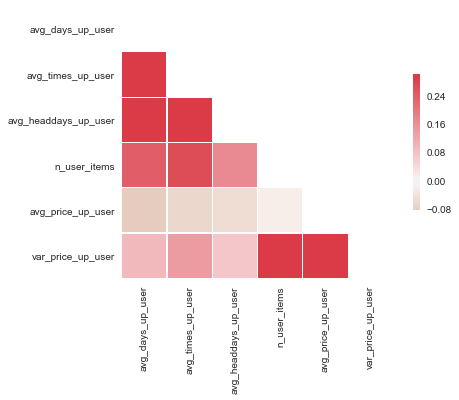

In [9]:
# User Data Agg
df = pd.read_feather('../features/train_active/Agg_User_train_active.feather')
df['n_user_items'] = np.log1p(df['n_user_items'])
df['avg_price_up_user'] = np.log(df['avg_price_up_user']+0.001)
df['var_price_up_user'] = np.log(df['var_price_up_user']+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)


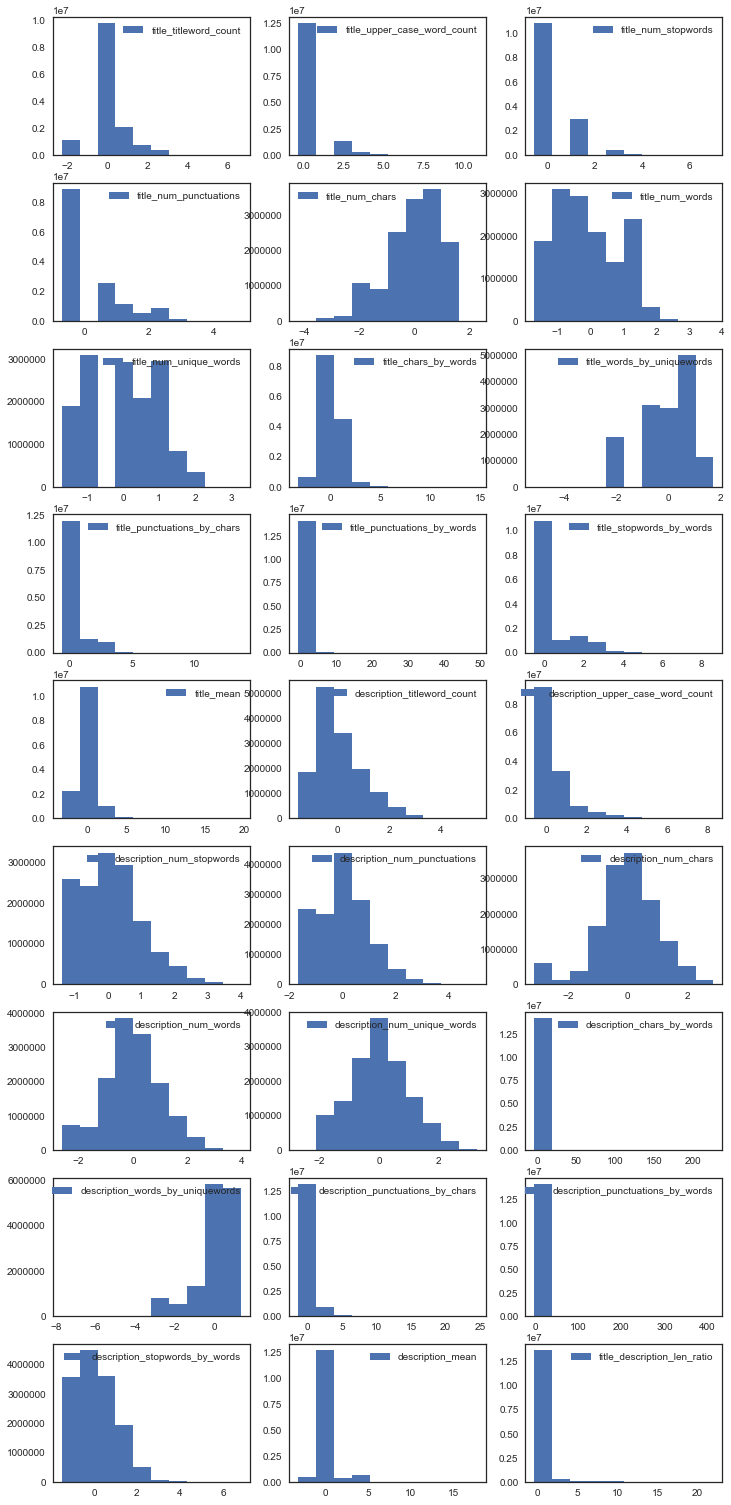

(14129821, 27)
Memory usage of dataframe is 2156.04 MB
Memory usage after optimization is: 1455.33 MB
Decreased by 32.5%
(14129821, 53)
2614.1980686187744  MB


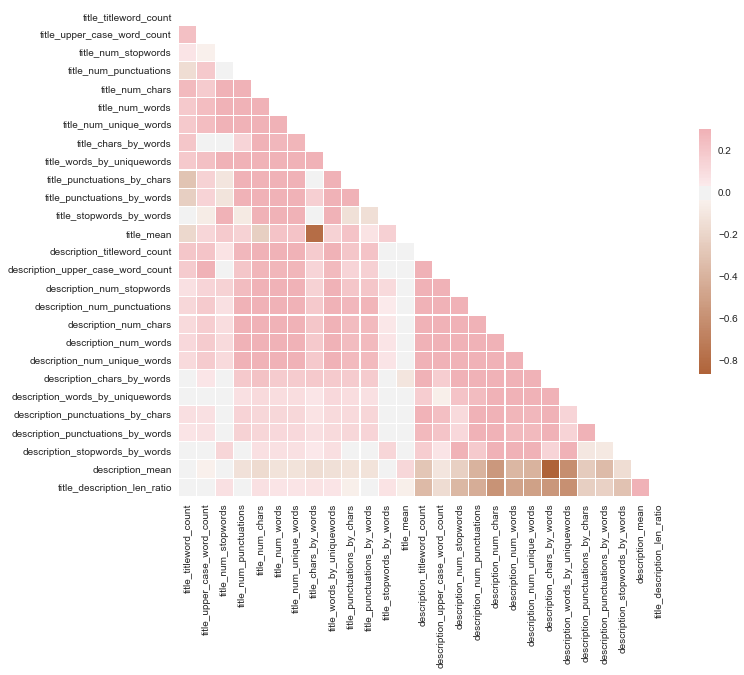

In [10]:
# Text features
df = pd.read_feather('../features/train_active/textfeatures_train_active.feather')
for col in df.columns:
    col_spl = col.split('_')
    #print(col, df[col].min(), df[col].max())
    if col_spl[-1] == 'count' or col_spl[-2] == 'num' or col.count('num_unique_words'):
        df[col] = np.log1p(df[col])
        df[col] = df[col].astype('float32')

# 意味のないcolは落とす
droplist = ['title_num_alphabets', 'title_num_digits', 'description_num_digits', 'description_num_alphabets',
            'title_digits_by_chars', 'title_alphabets_by_chars', 'description_digits_by_chars', 'description_alphabets_by_chars']
df = df.drop(droplist, axis=1)
df = scale_standard(df)

plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)


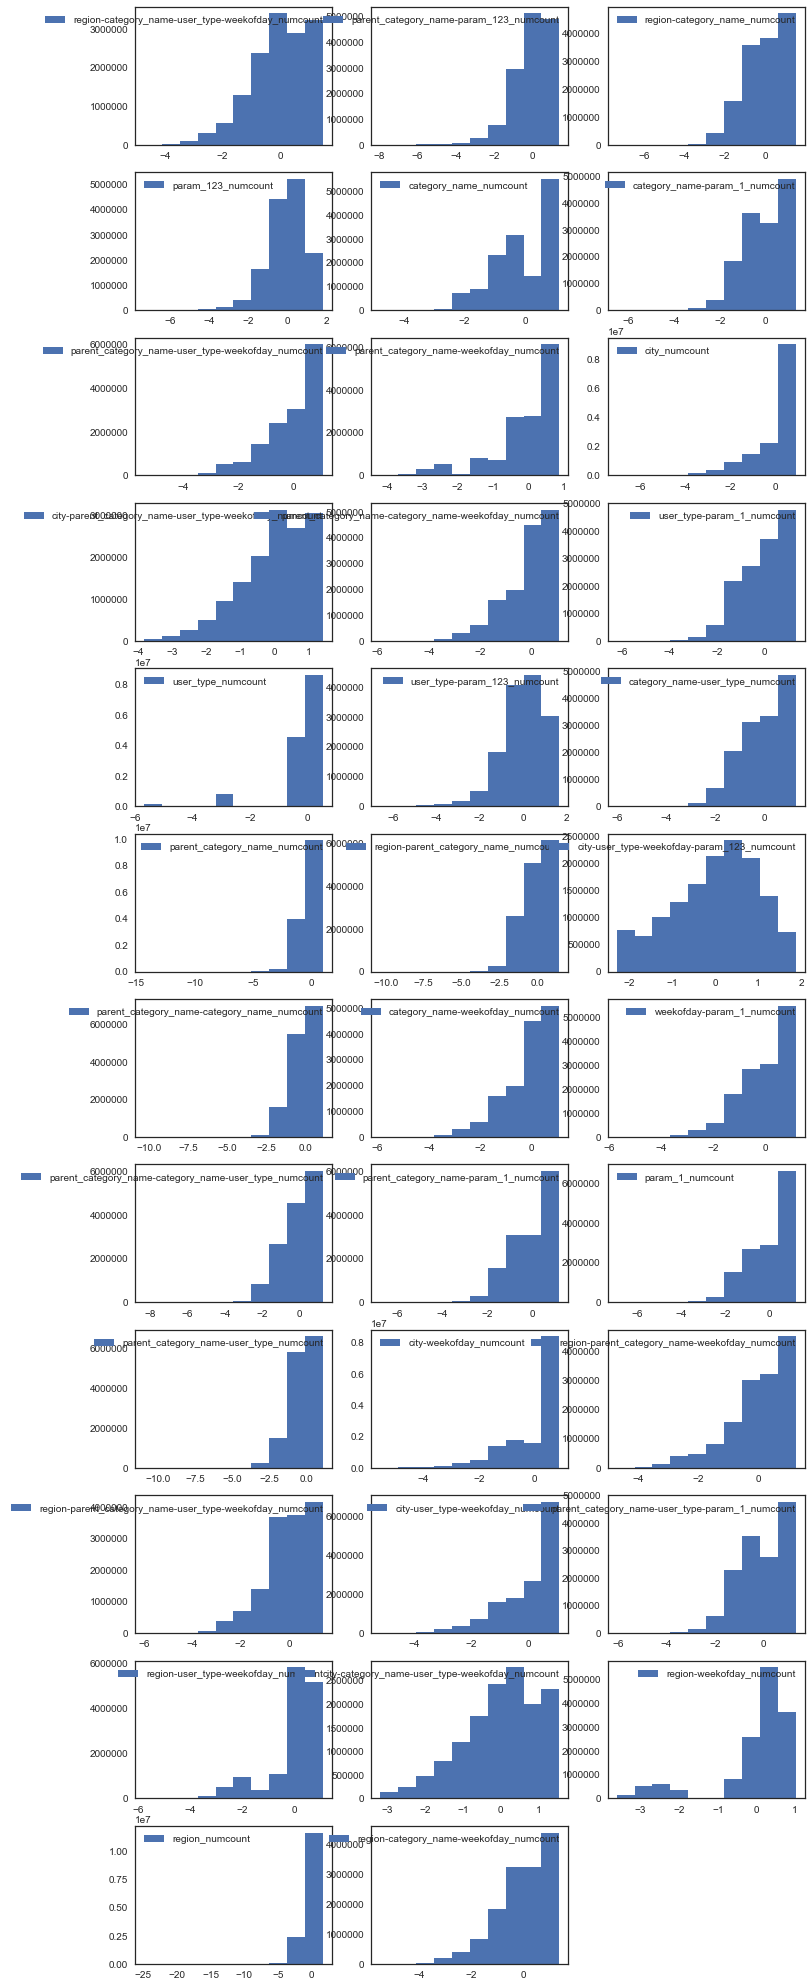

(14129821, 35)
Memory usage of dataframe is 3719.17 MB
Memory usage after optimization is: 1886.53 MB
Decreased by 49.3%
(14129821, 88)
4500.732702255249  MB


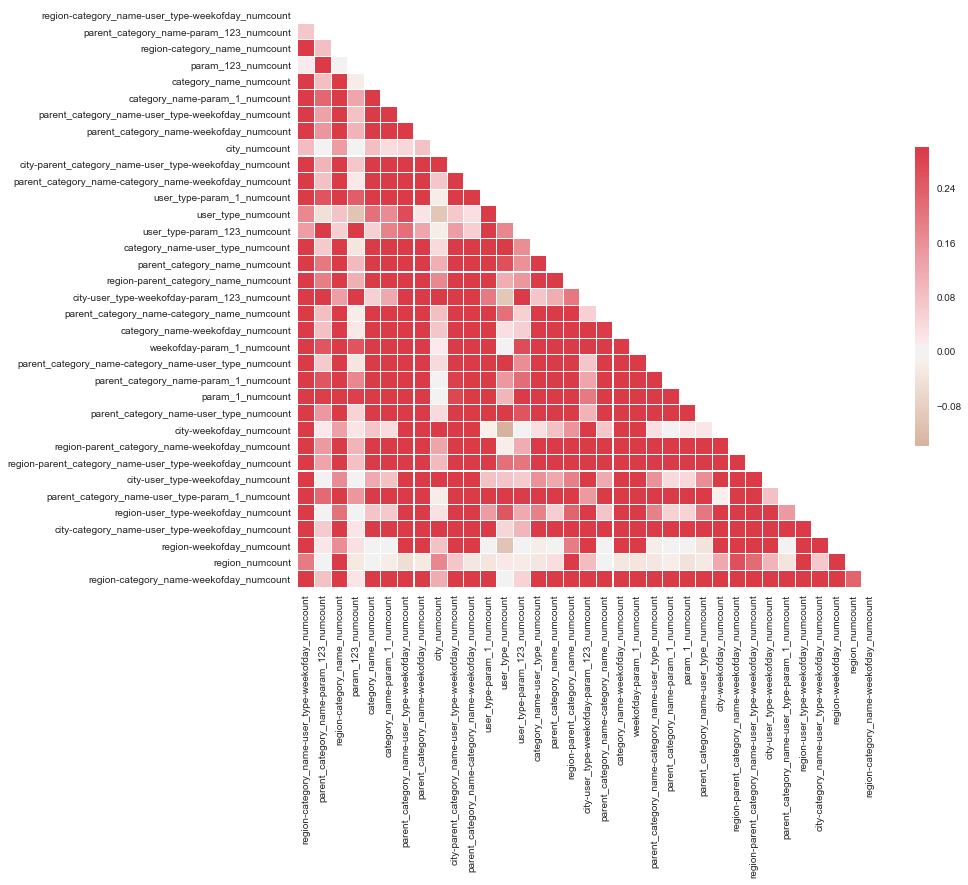

In [11]:
# Count Agg
df = pd.read_feather('../features/train_active/Agg_count_Golden_features_train_active.feather')
for col in df.columns:
    df[col] = np.log1p(df[col])
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)


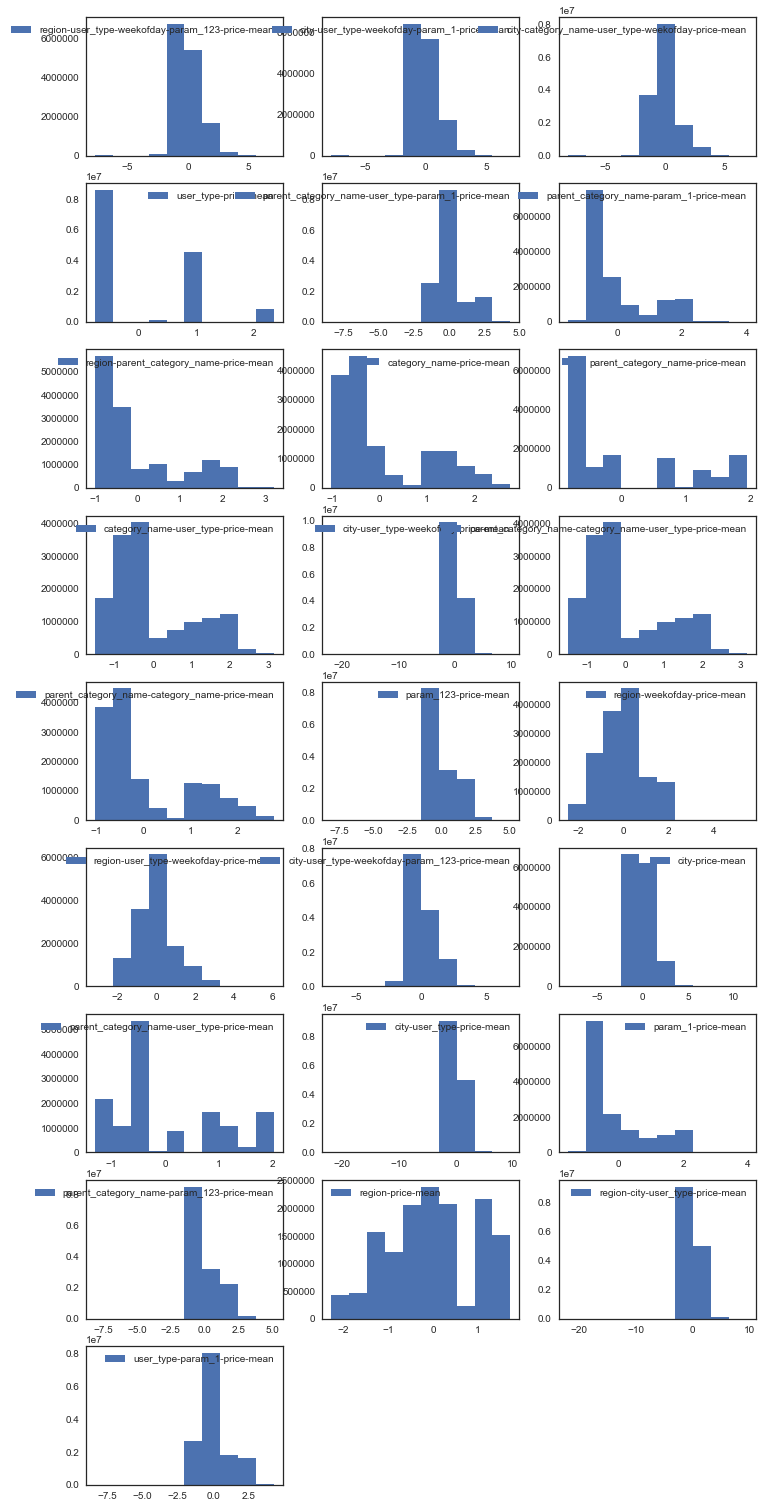

(14129821, 25)
Memory usage of dataframe is 1347.52 MB
Memory usage after optimization is: 1347.52 MB
Decreased by 0.0%
(14129821, 113)
5848.257440567017  MB


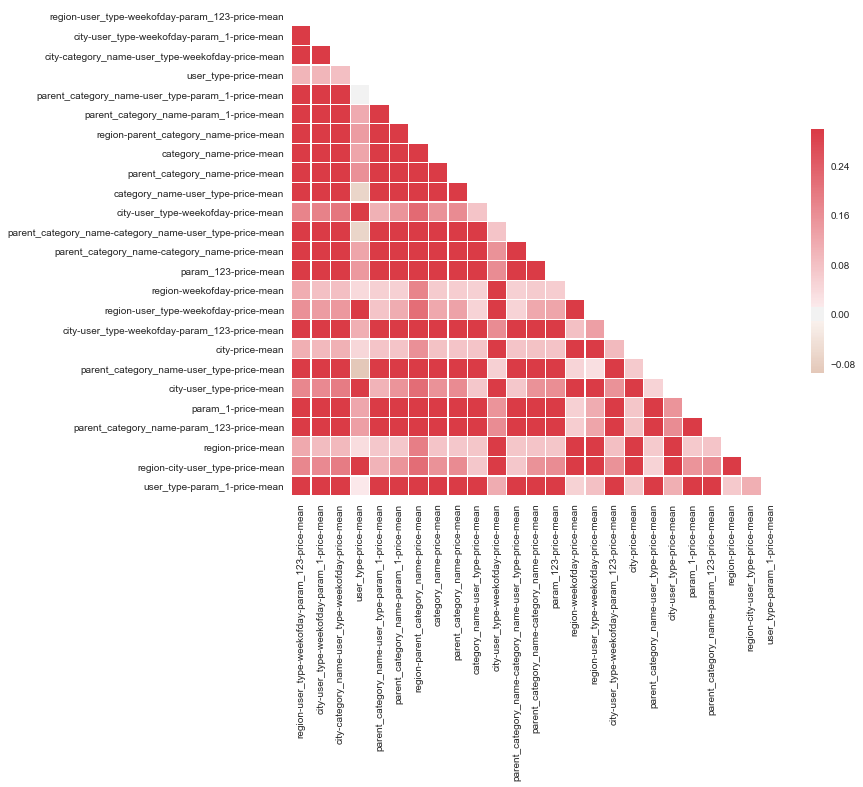

In [12]:
# Agg Price mean
df = pd.read_feather('../features/train_active/Agg_Price_mean_Golden_features_train_active.feather')
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)


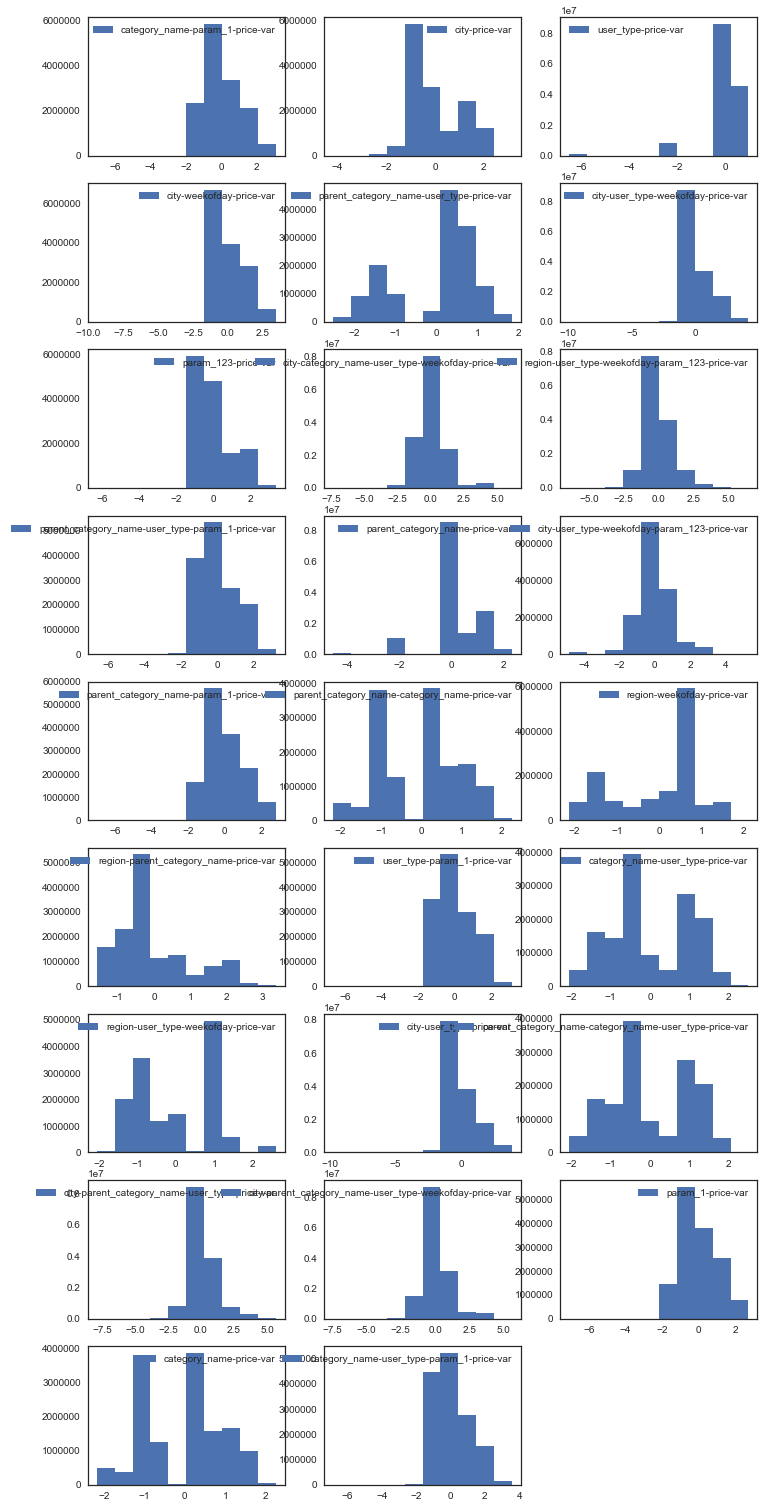

(14129821, 26)
Memory usage of dataframe is 1401.43 MB
Memory usage after optimization is: 1401.43 MB
Decreased by 0.0%
(14129821, 139)
7249.683168411255  MB


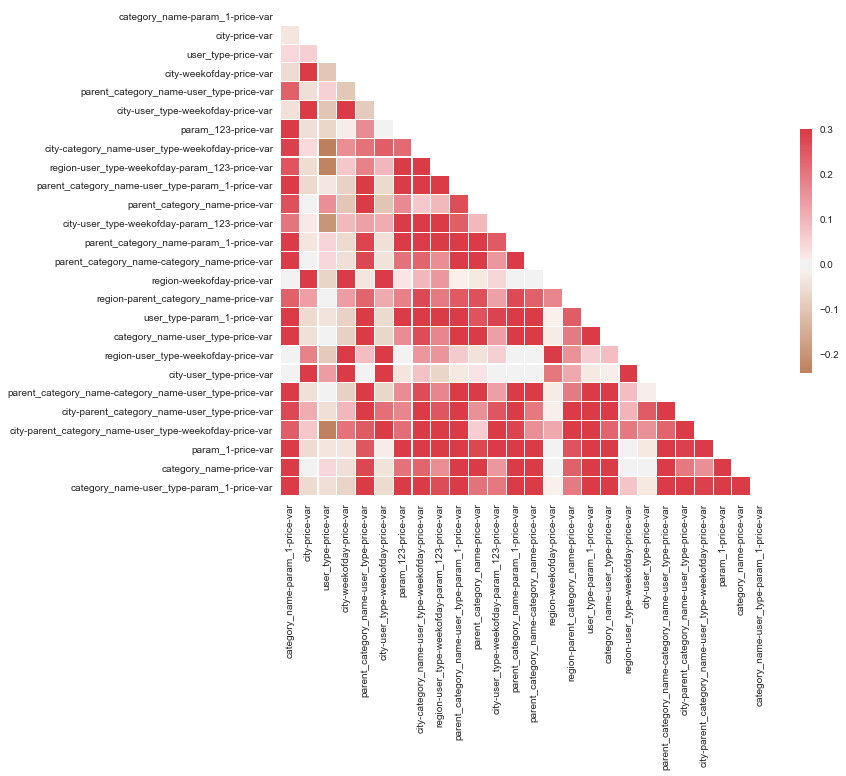

In [13]:
# Agg Price var
df = pd.read_feather('../features/train_active/Agg_Price_var_Golden_features_train_active.feather')
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)


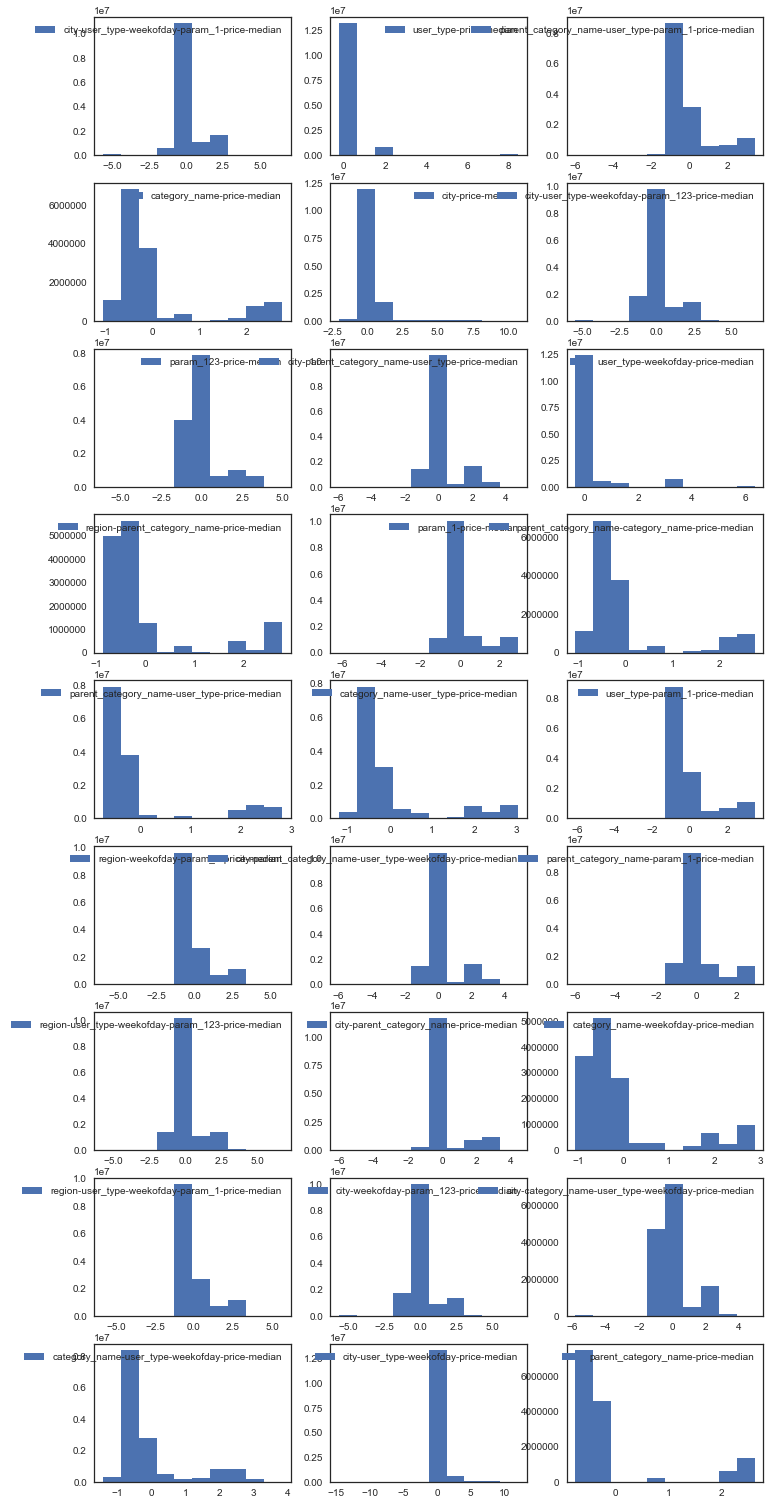

(14129821, 27)
Memory usage of dataframe is 1455.33 MB
Memory usage after optimization is: 1455.33 MB
Decreased by 0.0%
(14129821, 166)
8705.009885787964  MB


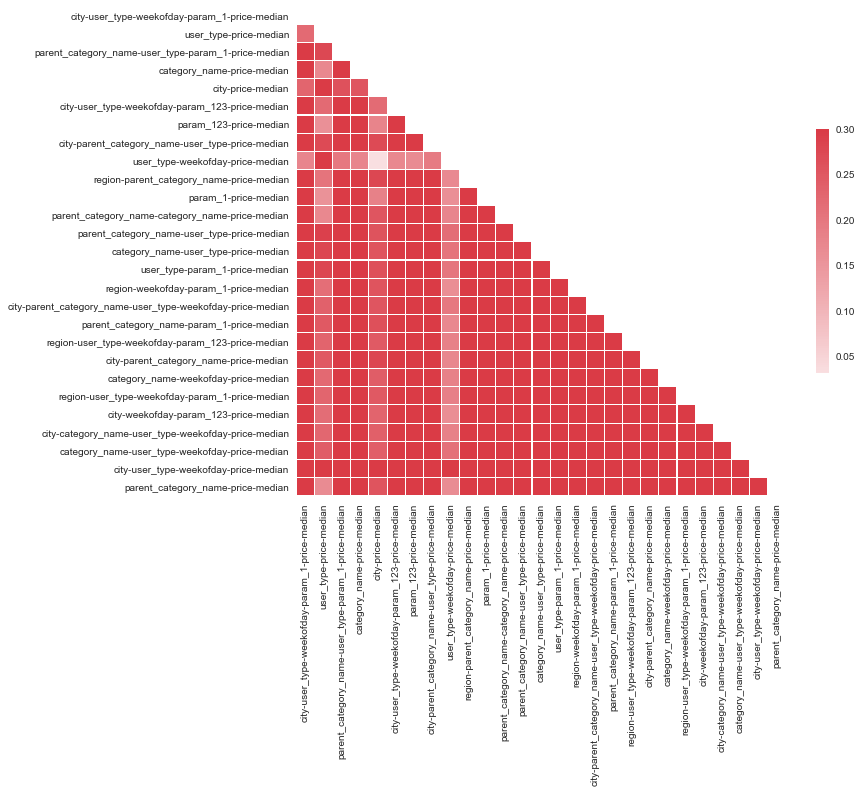

In [14]:
# Agg Price median
df = pd.read_feather('../features/train_active/Agg_Price_median_Golden_features_train_active.feather')
df = np.log(df+0.001)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

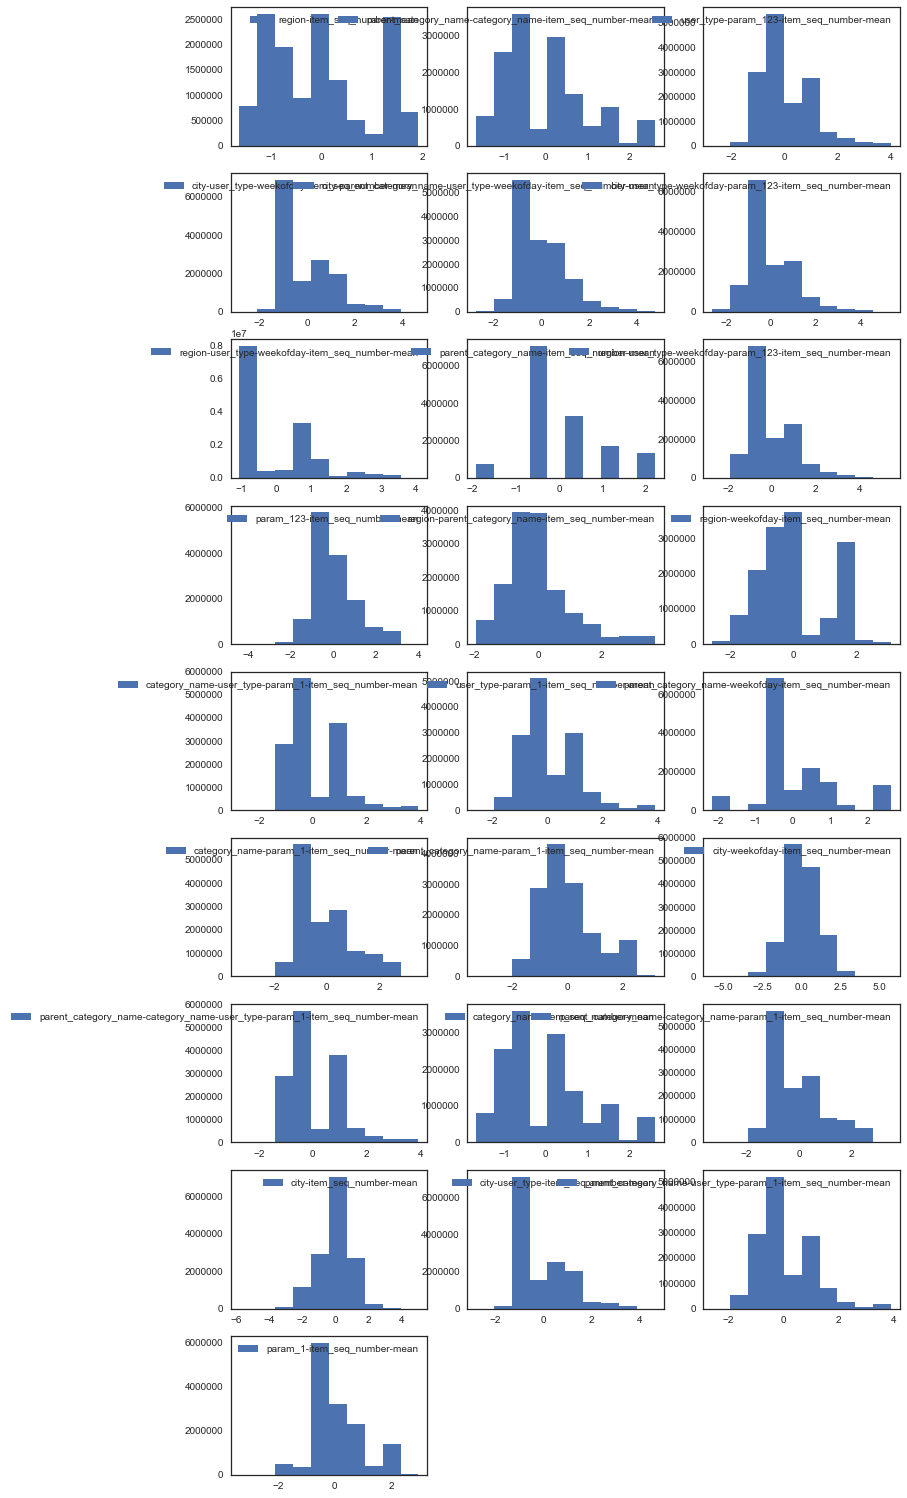

(14129821, 25)
Memory usage of dataframe is 1347.52 MB
Memory usage after optimization is: 1347.52 MB
Decreased by 0.0%
(14129821, 191)
10052.534624099731  MB


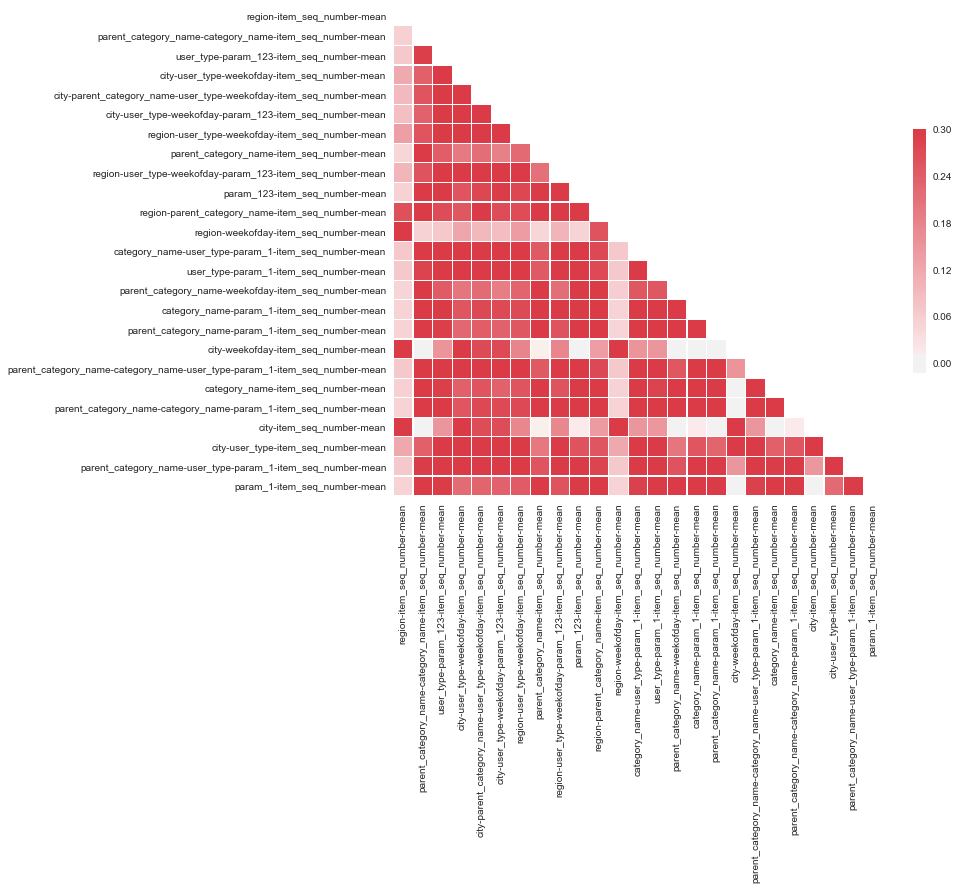

In [15]:
# Agg Itemseq Mean
df = pd.read_feather('../features/train_active/Agg_Itemseq_mean_Golden_features_train_active.feather')
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

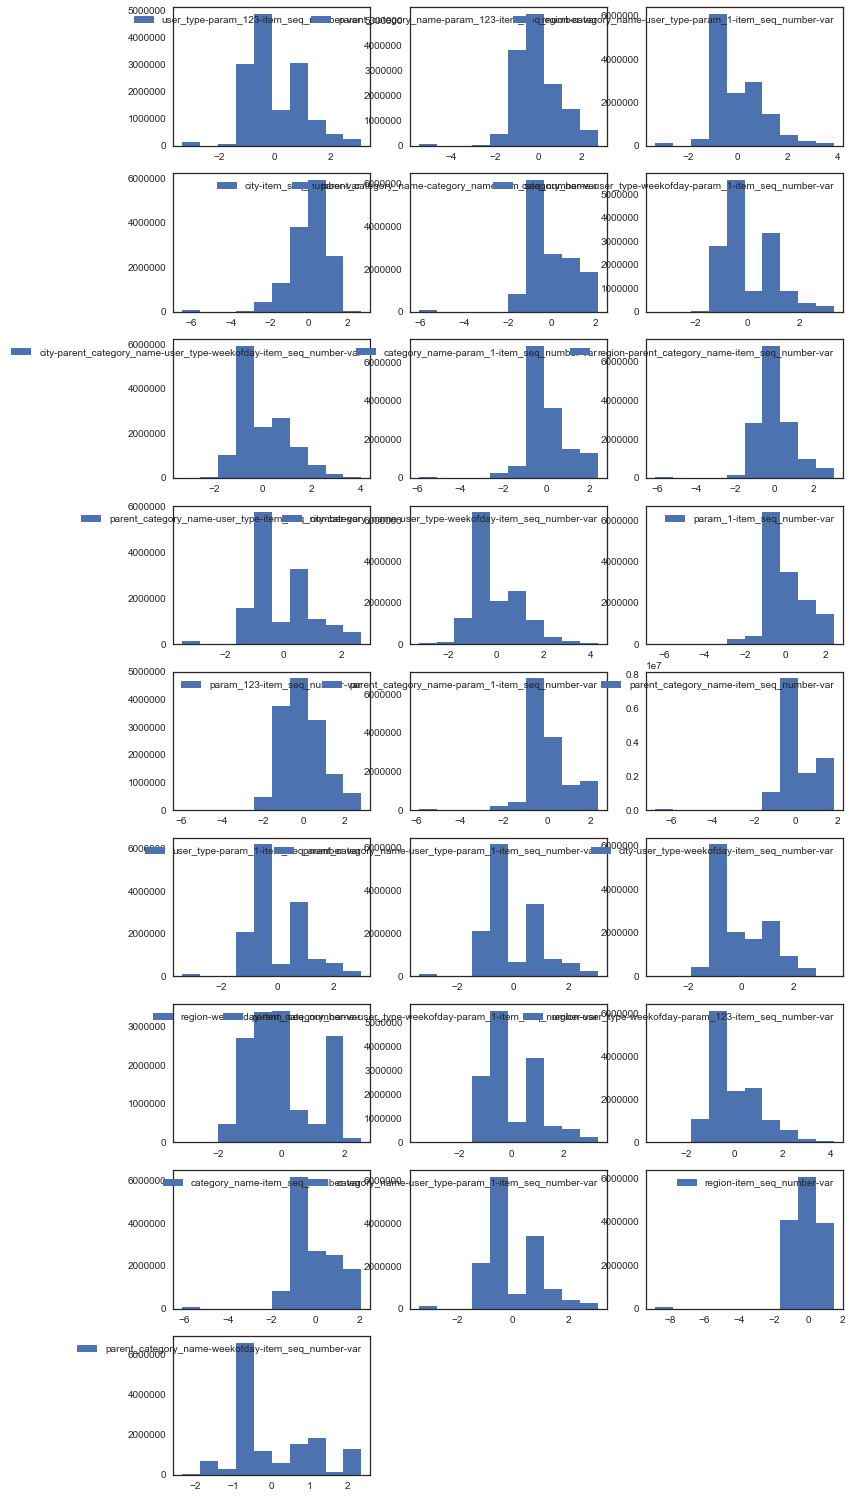

(14129821, 25)
Memory usage of dataframe is 1347.52 MB
Memory usage after optimization is: 1347.52 MB
Decreased by 0.0%
(14129821, 216)
11400.059362411499  MB


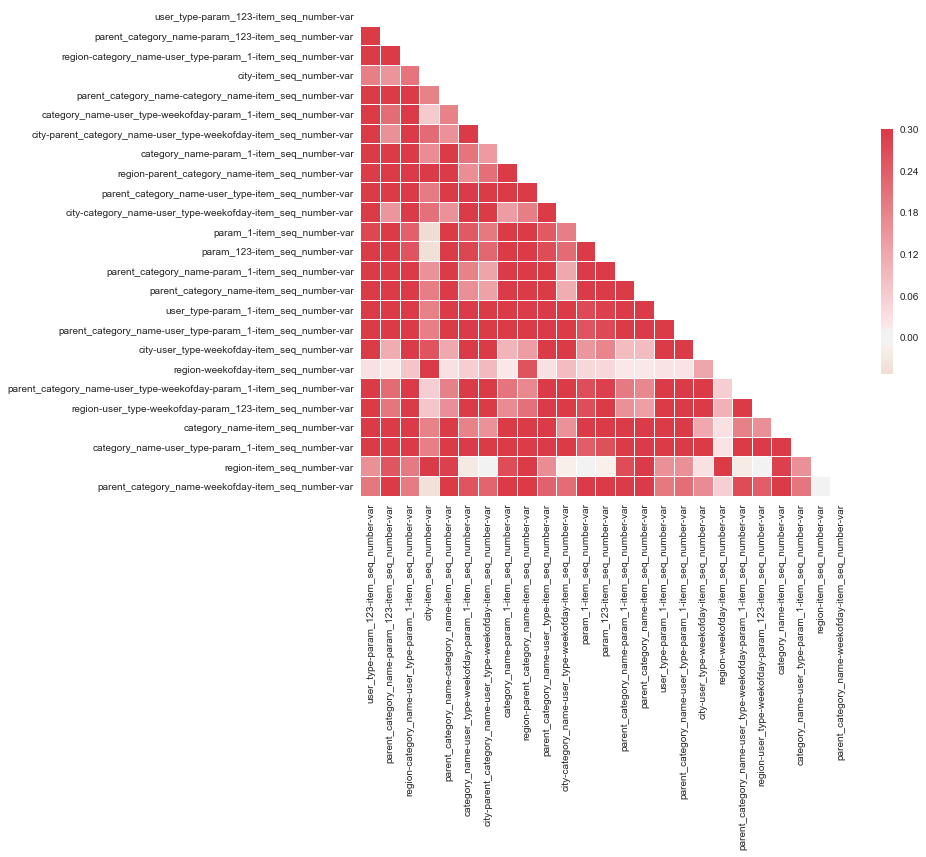

In [16]:
# Agg Itemseq var
df = pd.read_feather('../features/train_active/Agg_Itemseq_var_Golden_features_train_active.feather')
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

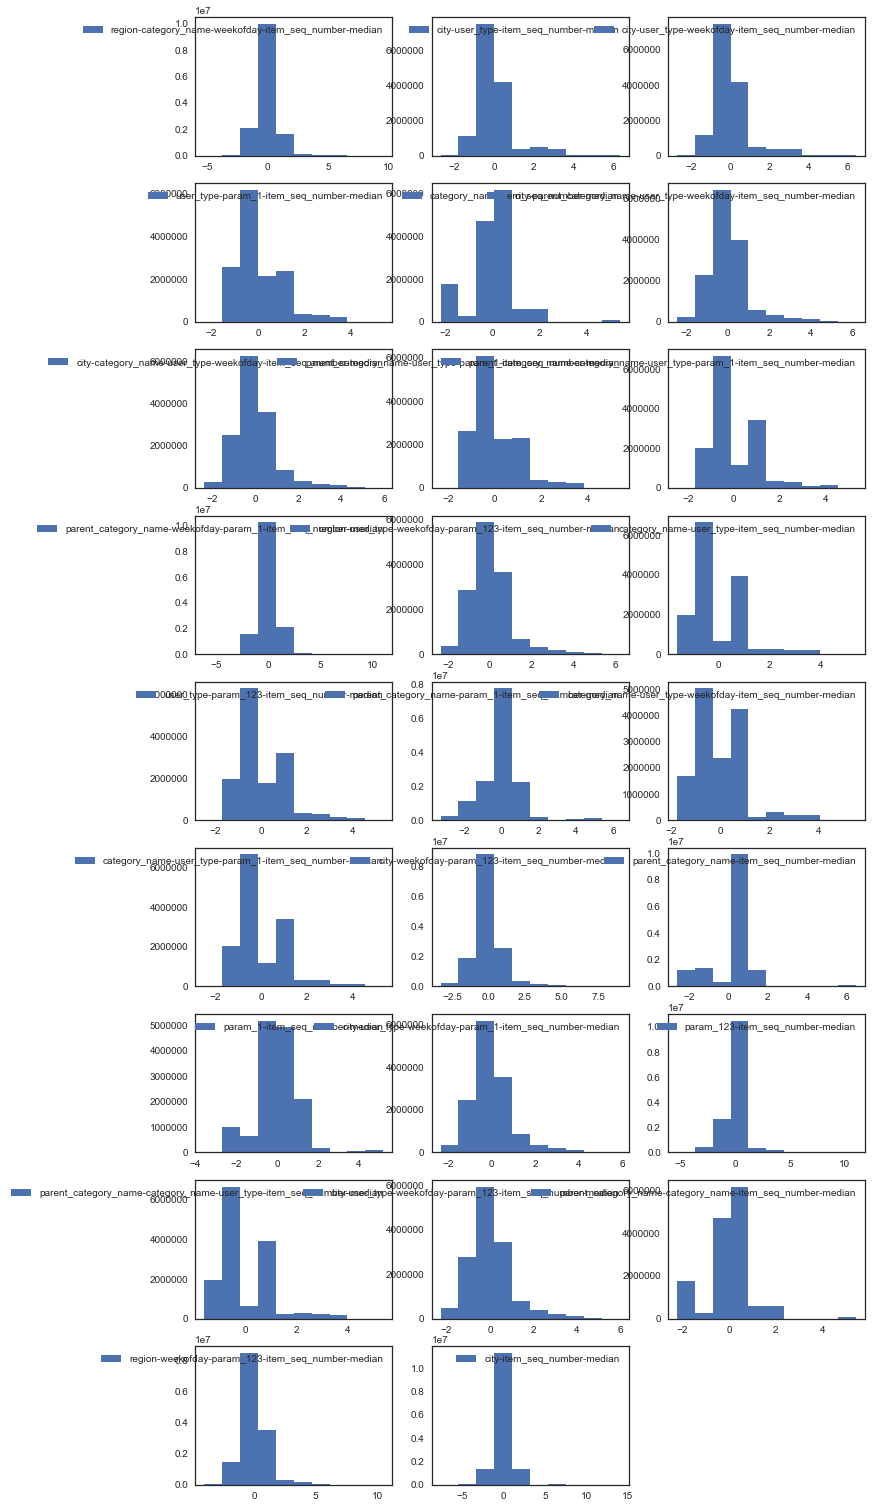

(14129821, 26)
Memory usage of dataframe is 1401.43 MB
Memory usage after optimization is: 1401.43 MB
Decreased by 0.0%
(14129821, 242)
12801.485090255737  MB


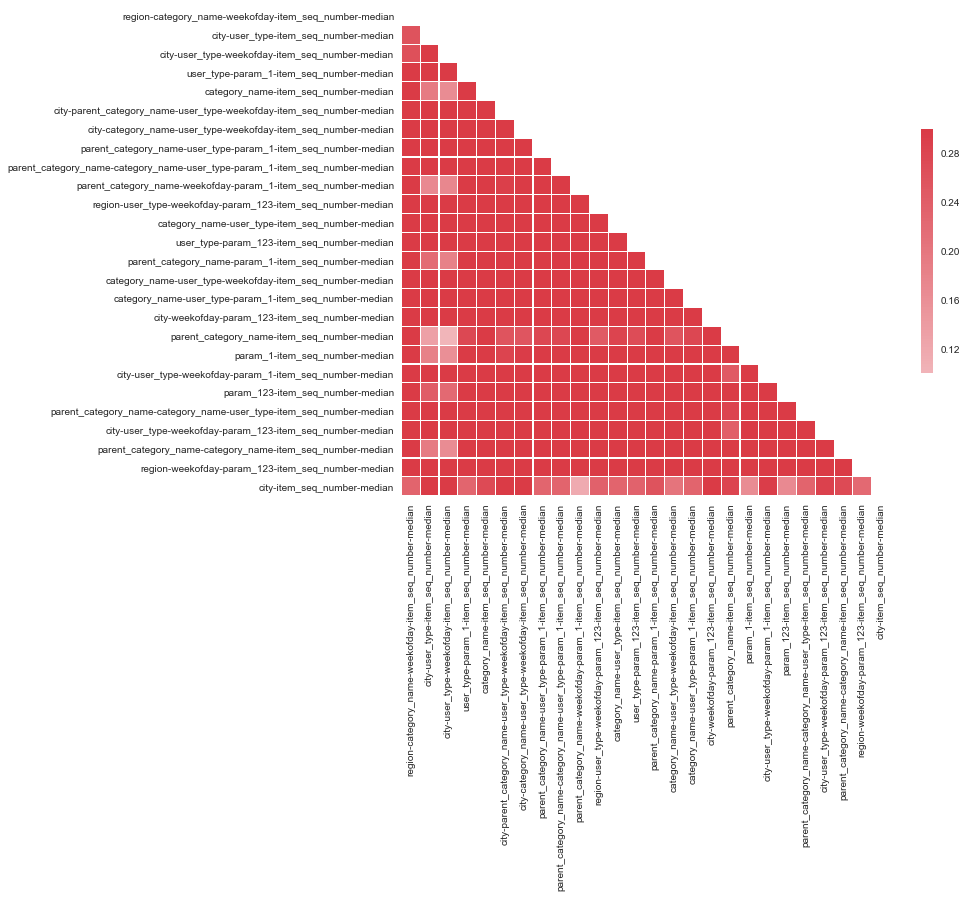

In [17]:
# Agg Itemseq Median
df = pd.read_feather('../features/train_active/Agg_Itemseq_median_Golden_features_train_active.feather')
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

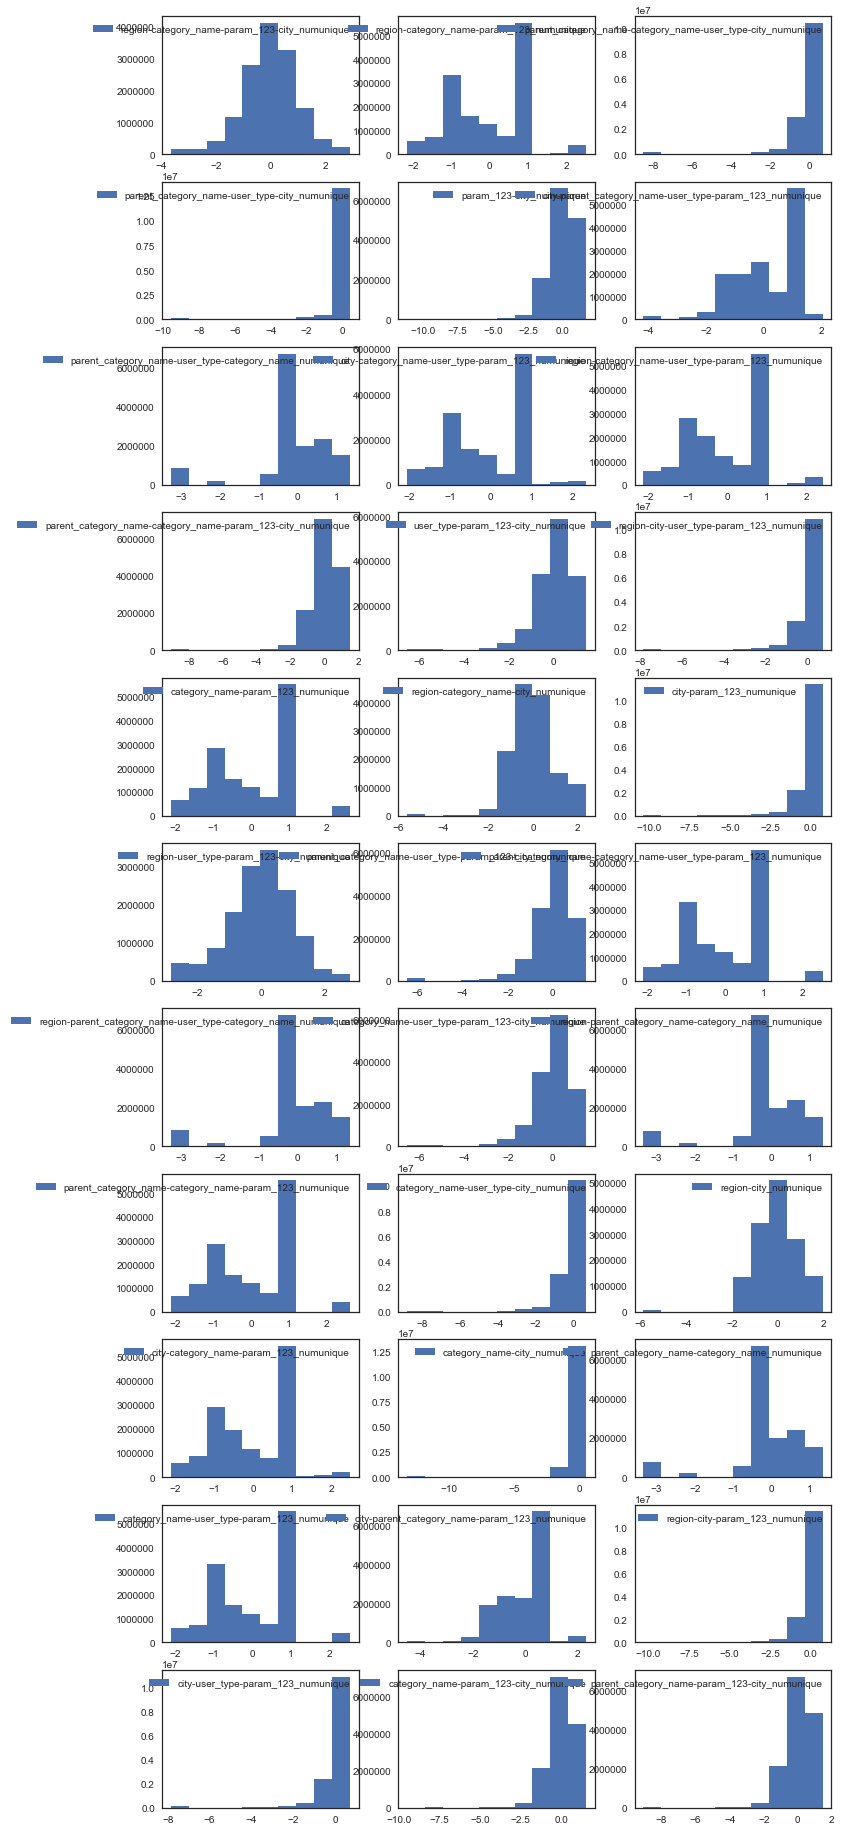

(14129821, 33)
Memory usage of dataframe is 1778.73 MB
Memory usage after optimization is: 1778.73 MB
Decreased by 0.0%
(14129821, 275)
14580.21774482727  MB


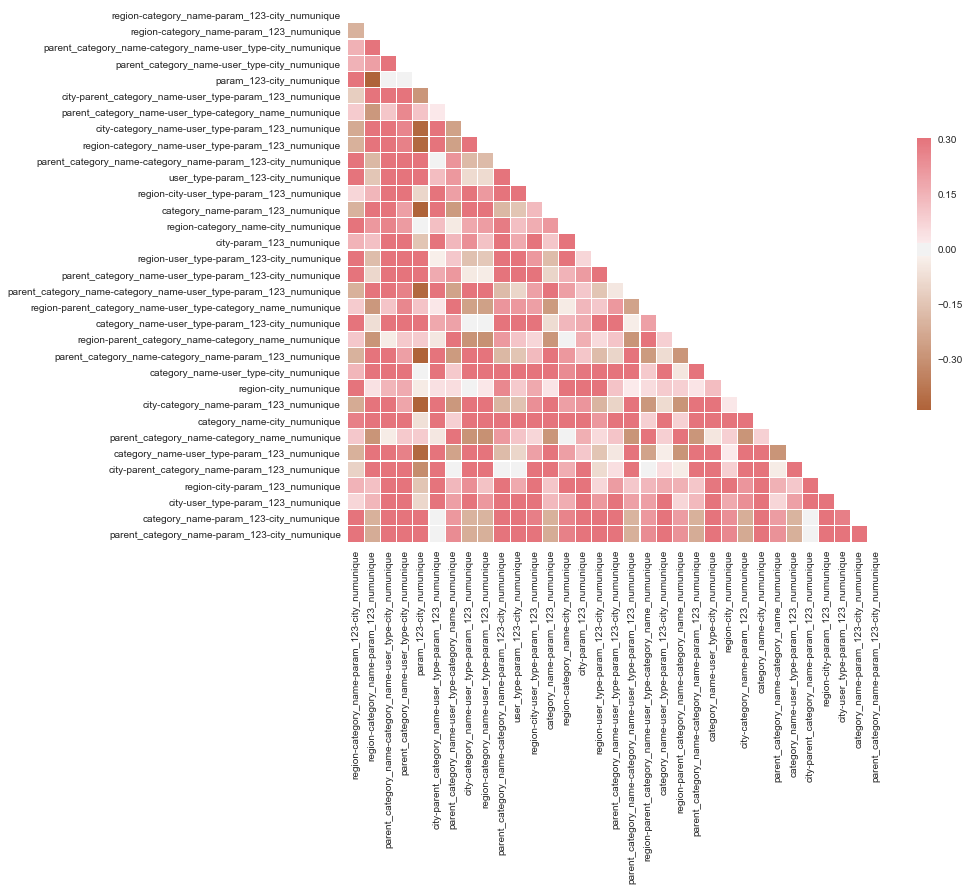

In [18]:
# Agg Nunique
df = pd.read_feather('../features/train_active/Agg_numunique_Golden_features_train_active.feather')
df = np.log1p(df)
df = scale_standard(df)
plothist(df)
plotcorr(df)
dfmaster = concat2master(df, dfmaster)

In [19]:
# Create semi-Supervised data
if 'weekofday' in dfmaster.columns:
    dfmaster.drop('weekofday', axis=1, inplace=True)

print(dfmaster.shape)

dfmaster.to_feather('../features/featured/train_active_semi.feather')


(14129821, 275)
